<a href="https://colab.research.google.com/github/ihuang87/Relative-Belief-Ratio/blob/main/Logistic_Regression_Sim_GoodCopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [ ]:
def binom_log_likelihood(p, y):
  return y * np.log(p) + (1 - y) * np.log(1 - p)

## Hypothesis Bia Aginast

In [ ]:
def hypothesis_bias_against_logistic(
    n_sample,
    X,
    hyp_betas,
    prior_mu,
    prior_sigma,
    n_datasets = 1000,
    n_marginal = 1000,
    cumulative = False
):
    """
    Estimate the bias against a hypothesis in a logistic regression model.

    Parameters:
    ----------
    n_sample : int
        The number of samples per dataset.

    X : ndarray of shape (n_sample, len(hyp_betas))
        The design matrix containing input features for the logistic model.

    hyp_betas : ndarray of shape (len(hyp_betas),)
        The hypothesized logistic regression coefficients.

    prior_mu : ndarray of shape (len(hyp_betas),)
        The mean vector of the prior distribution for the coefficients.

    prior_sigma : ndarray of shape (len(hyp_betas), len(hyp_betas))
        The covariance matrix of the prior distribution for the coefficients.

    n_datasets : int, optional, default=1000
        The number of simulated datasets to generate.

    n_marginal : int, optional, default=1000
        The number of prior samples used to estimate the marginal likelihood.

    cumulative : bool, optional, default=False
        If True, returns the cumulative bias after a "burn-in" period of 300 datasets.
        If False, returns the final bias value after all datasets.

    Returns:
    -------
    float or ndarray
        - If `cumulative` is False, returns a single float representing the final
          bias against the hypothesis after all datasets.
        - If `cumulative` is True, returns a 1D array of cumulative bias values
          (one value for each dataset after the burn-in period).
    """

    bias_against_sums = []

    # Generate data from the hypothesized betas along with the input design matrix
    logits = X @ hyp_betas
    p = np.exp(logits) / (1 + np.exp(logits))
    y = np.random.binomial(1, p = p, size = (n_datasets, n_sample))

    # Compute log-likelihood of y given the hypothesis
    log_likelihood = binom_log_likelihood(p, y)
    total_log_likelihood = log_likelihood.sum(axis=1)

    # Sample for betas from the prior
    betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_marginal)
    logits_pri = X @ betas.T
    p_pri = np.exp(logits_pri) / (1 + np.exp(logits_pri))
    y_repeated = np.repeat(y[:, np.newaxis, :], n_marginal, axis=1)
    y_repeated = y_repeated.transpose(2, 1, 0)

    # Calculate log-likelihood for each y given p, then sum across samples
    log_likelihood = binom_log_likelihood(p_pri[..., np.newaxis], y_repeated)  # Shape: (n_sample, n_marginal, n_datasets)
    log_likelihoods = log_likelihood.sum(axis=0)  # Sum over samples; result shape: (n_marginal, n_datasets)
    # Compute log marginal likelihood across all beta samples
    log_marginal_likelihood = logsumexp(log_likelihoods, axis=0) - np.log(n_marginal)

    # Calculate the bias against
    bias_against = (total_log_likelihood - log_marginal_likelihood) <= 0
    bias_against_sums = (bias_against.cumsum() / np.arange(1, len(bias_against) + 1))

    if cumulative:
        return bias_against_sums[300:]
    else:
        return bias_against_sums[-1]

In [ ]:
# Define parameters for simulations
n_sample = 20  # Number of samples per dataset
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples
prior_mu = np.zeros(2)  # Mean of the prior distribution for betas (2 parameters)
prior_sigma = np.eye(2)  # Covariance of the prior (identity for independent priors)
hyp_betas = np.array([0.0, 0.0])  # Hypothesized logistic regression coefficients
cumulative = True  # Compute cumulative bias against
num_iterations = 5

# Design matrix
X = np.ones((n_sample, len(hyp_betas)))
X[:int(n_sample/2),0] = 0
X[0:-1:2,1] = 0

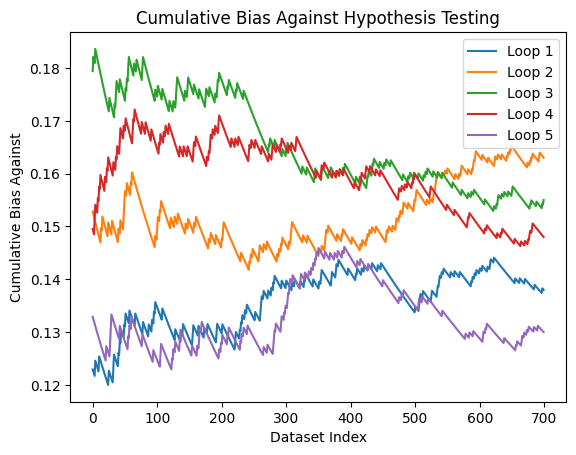

In [ ]:
all_bias_against_sums = []

for iteration in range(num_iterations):
    bias_against_sums = hypothesis_bias_against_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        cumulative=cumulative
    )
    all_bias_against_sums.append(bias_against_sums)
    plt.plot(bias_against_sums, label=f"Loop {iteration + 1}")

# Plot all results
plt.xlabel("Dataset Index")
plt.ylabel("Cumulative Bias Against")
plt.title("Cumulative Bias Against Hypothesis Testing")
plt.legend()
plt.show()

Changing sample size

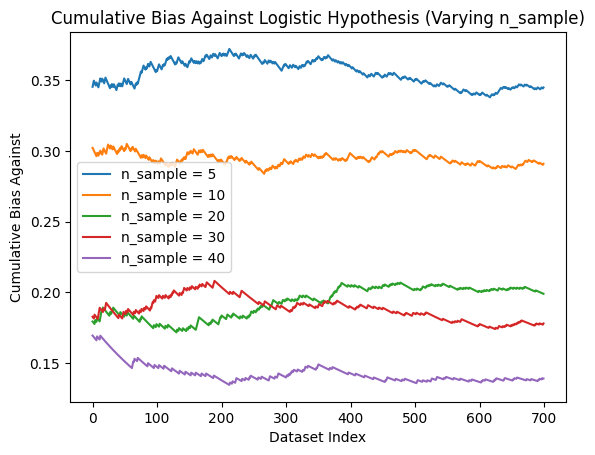

In [ ]:
# Varying sample size in different loops
n_samples = [5, 10, 20, 30, 40]

all_bias_against_sums = []

for n_sample in n_samples:
    # Generate synthetic X data
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample/2),0] = 0
    X[0:-1:2,1] = 0

    # Call the function
    bias_against_sums = hypothesis_bias_against_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        cumulative=cumulative
    )

    # Store and plot the results
    all_bias_against_sums.append(bias_against_sums)
    plt.plot(bias_against_sums, label=f"n_sample = {n_sample}")

# Plot all results
plt.xlabel("Dataset Index")
plt.ylabel("Cumulative Bias Against")
plt.title("Cumulative Bias Against Logistic Hypothesis (Varying n_sample)")
plt.legend()
plt.show()

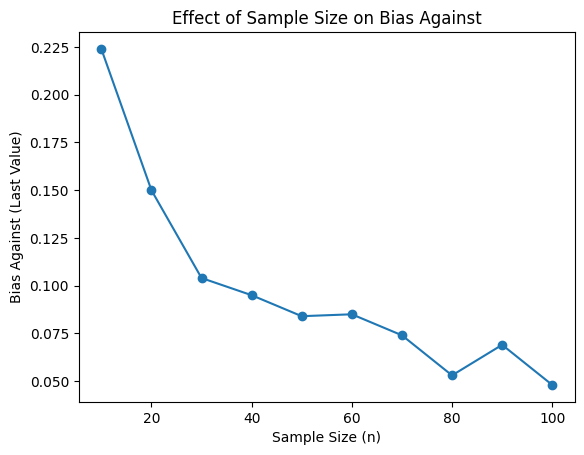

In [ ]:
n_samples = list(range(10, 100 + 1, 10))
all_bias_against_sums_2 = []

for n_sample in n_samples:
    # Create X matrix with size (n, p)
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample/2), 0] = 0
    X[0:-1:2, 1] = 0

    bias_against_sums = hypothesis_bias_against_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        cumulative=False,
    )
    all_bias_against_sums_2.append(bias_against_sums)


plt.plot(n_samples, all_bias_against_sums_2, marker='o')
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias Against (Last Value)")
plt.title("Effect of Sample Size on Bias Against")
plt.show()

Changing sigma

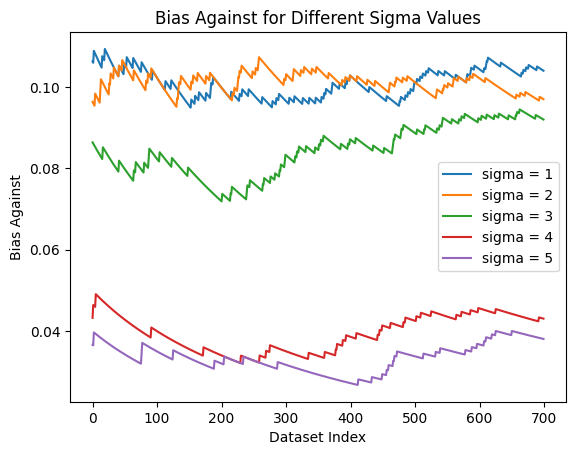

In [ ]:
sigmas = [1, 2, 3, 4, 5]
all_bias_against_sums = []

n_samples = 10
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples
prior_mu = np.zeros(2)  # Mean of the prior distribution for betas (2 parameters)
hyp_betas = np.array([0.0, 0.0])  # Hypothesized logistic regression coefficients
cumulative = True  # Compute cumulative bias against

for sigma in sigmas:
    # Create X matrix with size (n, p)
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample/2), 0] = 0
    X[0:-1:2, 1] = 0

    bias_against_sums = hypothesis_bias_against_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        prior_mu=prior_mu,
        prior_sigma=sigma*np.eye(len(hyp_betas)),
        cumulative=True,
    )
    all_bias_against_sums.append(bias_against_sums)

# Plot the results for each sigma
for sigma, bias_against_sums in zip(sigmas, all_bias_against_sums):
    plt.plot(bias_against_sums, label=f"sigma = {sigma}")

# Customize the plot
plt.xlabel("Dataset Index")
plt.ylabel("Bias Against")
plt.title("Bias Against for Different Sigma Values")
plt.legend()
plt.show()

In [ ]:
n_samples = list(range(10, 250 + 1, 10))
sigmas = [0.5, 1, 2, 5]
cumulative = False  # Compute final bias against

# Store results
results = {sigma: [] for sigma in sigmas}  # Store bias against for each sigma

# Loop through sigmas and n_samples
for sigma in sigmas:
    for n_sample in n_samples:
        # Create X matrix with size (n_sample, p)
        X = np.ones((n_sample, len(hyp_betas)))
        X[:int(n_sample / 2), 0] = 0
        X[0:-1:2, 1] = 0

        # Call the function
        bias_against = hypothesis_bias_against_logistic(
            n_sample=n_sample,
            X=X,
            hyp_betas=hyp_betas,
            n_datasets=n_datasets,
            n_marginal=n_marginal,
            prior_mu=prior_mu,
            prior_sigma=sigma * np.eye(len(hyp_betas)),
            cumulative=cumulative,
        )
        results[sigma].append(bias_against)

# Plot the results
for sigma, biases in results.items():
    plt.plot(n_samples, biases, label=f"sigma = {sigma}")

# Customize the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias Against")
plt.title("Hypothesis Testing: Bias Against vs. Sample Size")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.show()

KeyboardInterrupt: 

<ipython-input-2-9ccfcad6b19b>:2: RuntimeWarning: divide by zero encountered in log
  return y * np.log(p) + (1 - y) * np.log(1 - p)
<ipython-input-2-9ccfcad6b19b>:2: RuntimeWarning: invalid value encountered in multiply
  return y * np.log(p) + (1 - y) * np.log(1 - p)


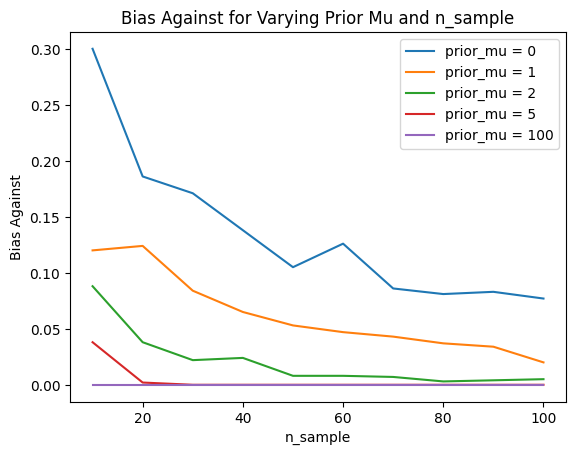

In [ ]:
n_samples = list(range(10, 100 + 1, 10))  # Varying sample sizes
prior_mus = [0, 1, 2, 5, 100]  # Different prior means
cumulative = False  # Compute final bias against
hyp_betas = np.array([0.0, 0.0])

# Store results
results = {mu: [] for mu in prior_mus}  # Store bias against for each prior_mu

# Loop through prior_mus and n_samples
for mu in prior_mus:
    for n_sample in n_samples:
        # Create X matrix with size (n_sample, p)
        X = np.ones((n_sample, len(hyp_betas)))
        X[:int(n_sample / 2), 0] = 0
        X[0:-1:2, 1] = 0

        # Call the function
        bias_against = hypothesis_bias_against_logistic(
            n_sample=n_sample,
            X=X,
            hyp_betas=hyp_betas,
            n_datasets=n_datasets,
            n_marginal=n_marginal,
            prior_mu=np.array([mu] * len(hyp_betas)),  # Prior mean varies
            prior_sigma=np.eye(len(hyp_betas)),  # Keep sigma fixed
            cumulative=cumulative,
        )
        results[mu].append(bias_against)

# Plot the results
for mu, biases in results.items():
    plt.plot(n_samples, biases, label=f"prior_mu = {mu}")

# Customize the plot
plt.xlabel("n_sample")
plt.ylabel("Bias Against")
plt.title("Bias Against for Varying Prior Mu and n_sample")
plt.legend()
plt.show()


# Estimation Bias Against

In [ ]:
def estimation_bias_against_logistic_non_vec(
    X,
    n_sample,
    n_param,
    prior_mu,
    prior_sigma,
    n_datasets = 1000,
    n_marginal = 1000,
    cumulative = False
):
    """
    Compute the bias against a logistic regression coefficients in hypothesis testing.

    Parameters
    ----------
    X : ndarray of shape (n_datasets, n_sample, n_param)
        The design matrix containing input features for the logistic model. Each dataset
        has `n_sample` samples and `n_param` features.

    n_sample : int
        The number of samples per dataset.

    n_param : int
        The number of parameters (features) in the logistic regression model.

    prior_mu : ndarray of shape (n_param,)
        The mean vector of the prior distribution for the regression coefficients.

    prior_sigma : ndarray of shape (n_param, n_param)
        The covariance matrix of the prior distribution for the regression coefficients.

    n_datasets : int, optional, default=1000
        The number of datasets to simulate.

    n_marginal : int, optional, default=1000
        The number of prior samples used for estimating the marginal likelihood.

    cumulative : bool, optional, default=False
        If True, returns the cumulative bias after a burn-in period of 300 datasets.
        If False, returns the final bias value after all datasets.

    Returns
    -------
    float or ndarray
        - If `cumulative` is False, returns a single float representing the final bias
          against the hypothesis.
        - If `cumulative` is True, returns a 1D array of cumulative bias values, one
          value for each dataset after the burn-in period.
    """

    # Generate the true coefficients for each dataset
    true_betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_datasets)

    # Generate sampled coefficients for estimating marginal likelihood
    betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_marginal)

    bias_against_sums = []

     # Generate data based on the true coeff above
    logits = np.einsum('ijk,ik->ij', X, true_betas)
    p = np.exp(logits) / (1 + np.exp(logits))
    y = np.random.binomial(1, p = p)

    # Compute log_likelihood of the data
    log_likelihood = binom_log_likelihood(p, y)
    log_likelihoods = log_likelihood.sum(axis=1)

    # Compute marginal log likelihood
    X_repeated = np.repeat(X[:, np.newaxis, :, :], n_marginal, axis=1)  # Shape: (n_datasets, n_marginal, n_sample, n_param)
    logits_pri = np.einsum('dmsp,mp->dms', X_repeated, betas)
    p_pri = np.exp(logits_pri) / (1 + np.exp(logits_pri))

    total_log_likelihood = np.zeros((n_datasets, n_marginal))
    for j in range(n_marginal):
        # Compute log-likelihood for all datasets for marginal j
        log_likelihood = y * np.log(p_pri[:, j, :]) + (1 - y) * np.log(1 - p_pri[:, j, :])
        total_log_likelihood[:, j] = log_likelihood.sum(axis=1)

    marginal_log_likelihood = logsumexp(total_log_likelihood, axis=1) - np.log(n_marginal)

    bias_against = (log_likelihoods - marginal_log_likelihood) <= 0

        # Compute the cumulative bias against (running mean of bias indicators)
    bias_against_sums = bias_against.cumsum() / np.arange(1, len(bias_against) + 1)

    # Return cumulative bias after burn-in (if cumulative=True), or the final bias value
    if cumulative:
        return bias_against_sums[300:]  # Return cumulative bias after burn-in period
    else:
        return bias_against_sums[-1]  # Return final bias in favor value

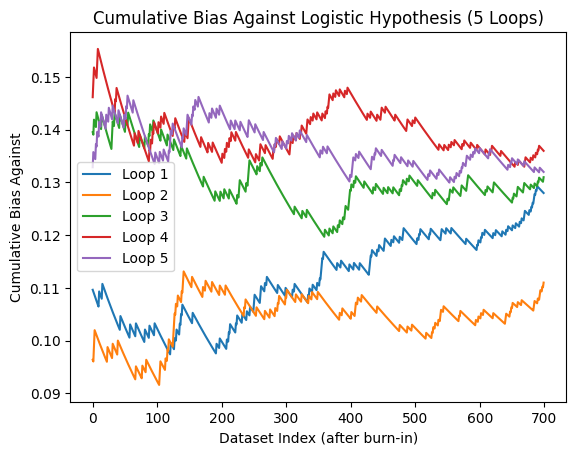

In [ ]:
# Define parameters
n_loops = 5
n_sample = 20  # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of samples for marginal likelihood estimation
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
prior_sigma = np.eye(n_param)  # Covariance matrix of the prior
cumulative = True  # Calculate cumulative bias against

# Generate synthetic design matrix X
X = np.ones((n_sample, n_param))
X[:int(n_sample/2), 0] = 0
X[0:-1:2, 1] = 0
X = np.tile(X, (n_datasets, 1, 1))


# Call the function
for i in range(n_loops):
    # Call the function
    bias_against_result = estimation_bias_against_logistic_non_vec(
        X=X,
        n_sample=n_sample,
        n_param=n_param,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )

    # Plot the cumulative bias for this loop
    plt.plot(bias_against_result, label=f"Loop {i+1}")

# Customize and display the plot
plt.xlabel("Dataset Index (after burn-in)")
plt.ylabel("Cumulative Bias Against")
plt.title("Cumulative Bias Against Logistic Hypothesis (5 Loops)")
plt.legend()
plt.show()


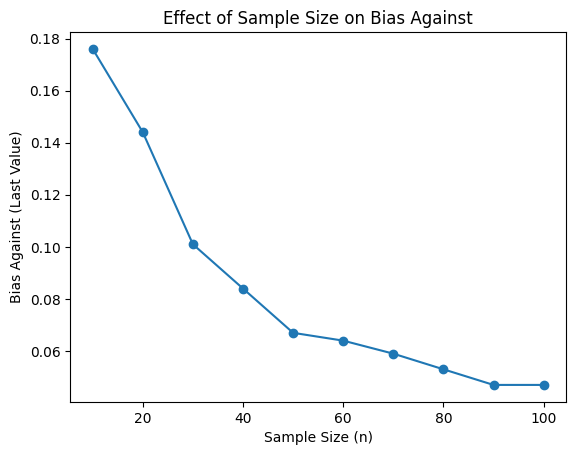

In [ ]:
# Varying sample size in one loop
n_samples = list(range(10, 100 + 1, 10))
all_bias_against_sums_2 = []

for n_sample in n_samples:
    # Create X matrix with size (n, p)
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample/2), 0] = 0
    X[0:-1:2, 1] = 0
    X = np.tile(X, (n_datasets, 1, 1))

    bias_against_sums = estimation_bias_against_logistic_non_vec(
        n_sample=n_sample,
        X=X,
        n_param=n_param,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        cumulative=False,
    )
    all_bias_against_sums_2.append(bias_against_sums)


plt.plot(n_samples, all_bias_against_sums_2, marker='o')
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias Against (Last Value)")
plt.title("Effect of Sample Size on Bias Against")
plt.show()

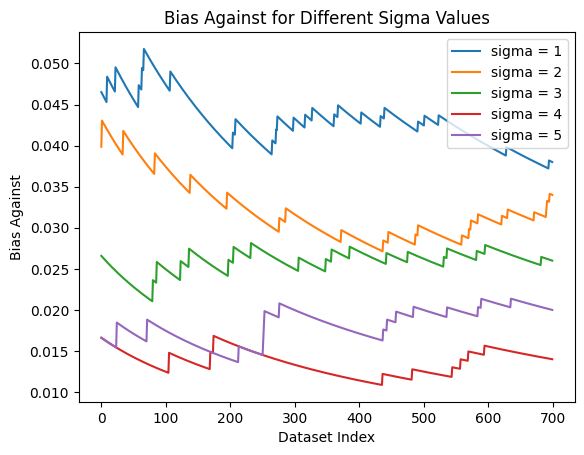

In [ ]:
sigmas = [1, 2, 3, 4, 5]
all_bias_against_sums = []

n_samples = 20
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples
prior_mu = np.zeros(2)  # Mean of the prior distribution for betas (2 parameters)
hyp_betas = np.array([1.0, -0.5])  # Hypothesized logistic regression coefficients
cumulative = True  # Compute cumulative bias against

for sigma in sigmas:
    # Create X matrix with size (n, p)
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample/2), 0] = 0
    X[0:-1:2, 1] = 0

    bias_against_sums = hypothesis_bias_against_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        prior_mu=prior_mu,
        prior_sigma=sigma*np.eye(len(hyp_betas)),
        cumulative=True,
    )
    all_bias_against_sums.append(bias_against_sums)

# Plot the results for each sigma
for sigma, bias_against_sums in zip(sigmas, all_bias_against_sums):
    plt.plot(bias_against_sums, label=f"sigma = {sigma}")

# Customize the plot
plt.xlabel("Dataset Index")
plt.ylabel("Bias Against")
plt.title("Bias Against for Different Sigma Values")
plt.legend()
plt.show()

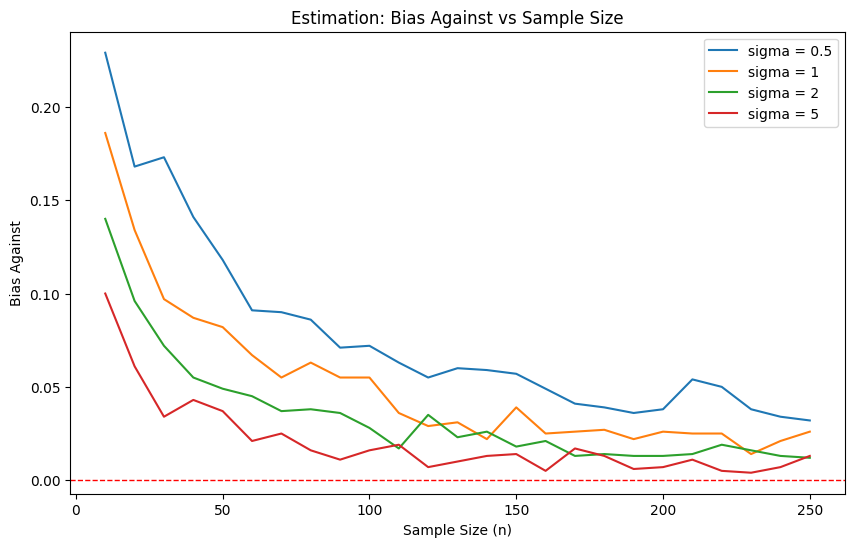

In [ ]:
# Define parameters
n_samples = list(range(10, 250 + 1, 10))  # Varying sample sizes
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of samples for marginal likelihood estimation
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
sigmas = [0.5, 1, 2, 5] # Different sigma values
cumulative = False  # Compute final bias against

# Store results
results = {sigma: [] for sigma in sigmas}  # Store bias against for each sigma

# Run simulations
for sigma in sigmas:
    for n_sample in n_samples:
        # Generate synthetic design matrix X for current sample size
        X = np.ones((n_sample, n_param))
        X[:int(n_sample / 2), 0] = 0
        X[0:-1:2, 1] = 0
        X = np.tile(X, (n_datasets, 1, 1))  # Replicate for all datasets

        # Call the function
        bias_against_result = estimation_bias_against_logistic_non_vec(
            X=X,
            n_sample=n_sample,
            n_param=n_param,
            prior_mu=prior_mu,
            prior_sigma=sigma * np.eye(n_param),  # Scale prior covariance by sigma
            n_datasets=n_datasets,
            n_marginal=n_marginal,
            cumulative=cumulative,
        )

        # Store the result
        results[sigma].append(np.mean(bias_against_result))  # Mean bias for the current sigma and sample size

# Plot results
plt.figure(figsize=(10, 6))
for sigma in sigmas:
    plt.plot(n_samples, results[sigma], label=f"sigma = {sigma}")

# Customize and display the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias Against")
plt.title("Estimation: Bias Against vs Sample Size")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.show()


# Hypothesis Bias in Favour

In [ ]:
def hypothesis_bias_in_favour_logistic(
    n_sample,
    X,
    hyp_betas,
    delta,
    prior_mu,
    prior_sigma,
    n_datasets = 1000,
    n_marginal = 1000,
    cumulative = False
):
    """
    Compute the bias in favor of a logistic regression.

    Parameters
    ----------
    n_sample : int
        Number of samples per dataset.

    X : ndarray of shape (n_sample, n_features)
        Design matrix containing input features for the logistic regression model.

    hyp_betas : ndarray of shape (n_features,)
        The hypothesized logistic regression coefficients.

    delta : float
        The amount of perturbation applied to each coefficient to create alternative hypotheses.

    prior_mu : ndarray of shape (n_features,)
        Mean vector of the prior distribution for regression coefficients.

    prior_sigma : ndarray of shape (n_features, n_features)
        Covariance matrix of the prior distribution for regression coefficients.

    n_datasets : int, optional, default=1000
        Number of datasets to simulate.

    n_marginal : int, optional, default=1000
        Number of prior samples used to estimate the marginal likelihood.

    cumulative : bool, optional, default=False
        Whether to return cumulative bias values after a burn-in period.
        If False, returns only the final bias value.

    Returns
    -------
    ndarray or float
        - If `cumulative=True`, returns a 1D array of cumulative bias values after the burn-in period.
        - If `cumulative=False`, returns a single float representing the final bias in favor.
    """

    bias_in_fav_sums = []
    sampled_betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_marginal)

    for i in range(len(hyp_betas)):
        for shift in [+delta, -delta]:
          shifted_betas = hyp_betas.copy()
          shifted_betas[i] += shift  # Shift only the i-th parameter

    # Generate data from with true shifted betas and the input design matrix
          true_logits = X @ shifted_betas
          true_p = np.exp(true_logits) / (1 + np.exp(true_logits))
          y = np.random.binomial(1, p = true_p, size = (n_datasets, n_sample))

    # Calculate logits and probabilities based on hyp_betas(not true)
          logits = X @ hyp_betas
          p = np.exp(logits) / (1 + np.exp(logits))

    # Compute log-likelihood of y given the hypothesis
          log_likelihood = binom_log_likelihood(p, y)
          total_log_likelihood = log_likelihood.sum(axis=1)

          # betas from the prior
          logits_pri = X @ sampled_betas.T
          p_pri = np.exp(logits_pri) / (1 + np.exp(logits_pri))
          y_repeated = np.repeat(y[:, np.newaxis, :], n_marginal, axis=1)
          y_repeated = y_repeated.transpose(2, 1, 0)

          # Calculate log-likelihood for each y given p, then sum across samples
          log_likelihood = binom_log_likelihood(p_pri[..., np.newaxis], y_repeated)  # Shape: (n_sample, n_marginal, n_datasets)
          log_likelihoods = log_likelihood.sum(axis=0)  # Sum over samples; result shape: (n_marginal, n_datasets)
          # Compute log marginal likelihood across all beta samples
          log_marginal_likelihood = logsumexp(log_likelihoods, axis=0) - np.log(n_marginal)

    # Calculate the bias against
          bias_in_fav = (total_log_likelihood - log_marginal_likelihood) > 0
          bias_in_fav_sum = bias_in_fav.cumsum() / np.arange(1, len(bias_in_fav) + 1)
          bias_in_fav_sums.append(bias_in_fav_sum)
    # print(np.mean(bias_in_fav))

    final_bias_sums = max(bias_in_fav_sums, key=lambda x: x[-1])
    # print(len(bias_in_fav_sums))

    if cumulative:
        return final_bias_sums[200:]
    else:
        return final_bias_sums[-1]

## Prior centered at null

Effect of δ

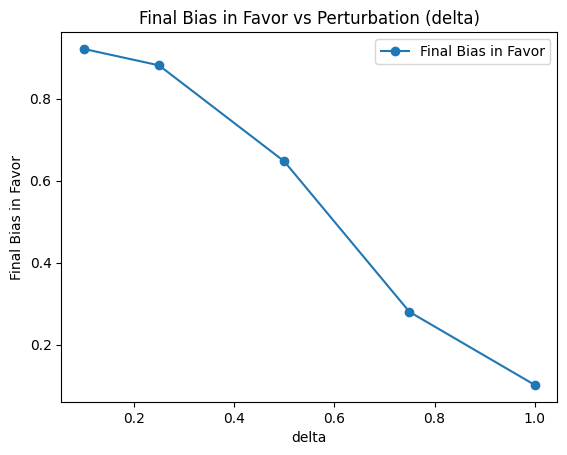

In [ ]:
# Define parameters
n_sample = 100  # Fixed sample size
deltas = [0.1, 0.25, 0.5, 0.75, 1]  # Varying delta values (will be the x-axis)
prior_sigma = np.eye(n_param)  # Covariance matrix of the prior

# Store results
final_bias_values = []

# Generate a synthetic design matrix X (same for all deltas)
X = np.ones((n_sample, len(hyp_betas)))
X[:int(n_sample / 2), 0] = 0
X[0:-1:2, 1] = 0

# Loop through varying delta
for delta in deltas:
    # Call the function with the current delta
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs delta
plt.plot(deltas, final_bias_values, label="Final Bias in Favor")
plt.xlabel("delta")
plt.ylabel("Final Bias in Favor")
plt.title("Hypothesis Testing: Bias in Favor vs delta")
plt.legend()
plt.show()

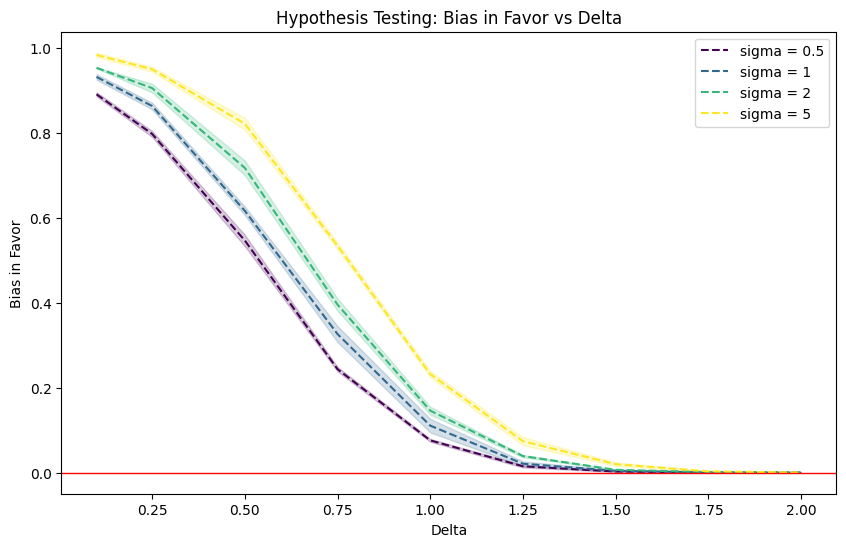

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters
n_loops = 3  # Number of simulation loops for averaging
n_sample = 100  # Fixed sample size
deltas = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0]  # Varying delta values (x-axis)
sigmas = [0.5, 1, 2, 5]  # Varying sigma values
n_param = 2  # Number of parameters (features)
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of marginal samples
prior_mu = np.zeros(n_param)  # Prior mean
cumulative = True  # Whether to calculate cumulative bias

# Store results
results = {sigma: {delta: [] for delta in deltas} for sigma in sigmas}

# Generate a synthetic design matrix X
X = np.ones((n_sample, n_param))
X[:int(n_sample / 2), 0] = 0
X[0:-1:2, 1] = 0

# Run simulations for multiple loops
for sim in range(n_loops):
    for sigma in sigmas:
        for delta in deltas:
            # Call the function for each sigma and delta
            bias_in_favour = hypothesis_bias_in_favour_logistic(
                n_sample=n_sample,
                X=X,
                hyp_betas=prior_mu,  # Assuming hyp_betas matches prior_mu
                delta=delta,
                prior_mu=prior_mu,
                prior_sigma=sigma * np.eye(n_param),  # Scale prior covariance
                n_datasets=n_datasets,
                n_marginal=n_marginal,
                cumulative=cumulative,
            )

            # Store the final bias value (last cumulative value)
            results[sigma][delta].append(bias_in_favour[-1])

# Calculate mean and confidence intervals
mean_results = {sigma: [] for sigma in sigmas}
conf_intervals = {sigma: [] for sigma in sigmas}

for sigma in sigmas:
    for delta in deltas:
        biases = results[sigma][delta]
        mean_bias = np.mean(biases)
        std_error = np.std(biases) / np.sqrt(n_loops)  # Standard error
        z_score = norm.ppf(0.975)  # For 95% confidence interval
        conf_interval = z_score * std_error

        mean_results[sigma].append(mean_bias)
        conf_intervals[sigma].append(conf_interval)

# Plot results with color-coded confidence intervals
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sigmas)))  # Generate distinct colors

for idx, sigma in enumerate(sigmas):
    mean_bias = mean_results[sigma]
    conf_interval = conf_intervals[sigma]
    lower_bound = [m - c for m, c in zip(mean_bias, conf_interval)]
    upper_bound = [m + c for m, c in zip(mean_bias, conf_interval)]

    # Plot the mean line
    plt.plot(deltas, mean_bias, linestyle='--', label=f"sigma = {sigma}", color=colors[idx])

    # Fill the confidence interval
    plt.fill_between(
        deltas,
        lower_bound,
        upper_bound,
        alpha=0.2,
        color=colors[idx],
    )

# Add a red horizontal line at y=0
plt.axhline(y=0, color='red', linewidth=1,)

# Customize the plot
plt.xlabel("Delta")
plt.ylabel("Bias in Favor")
plt.title("Hypothesis Testing: Bias in Favor vs Delta")
plt.legend()
plt.show()


### Prior centered at null with σ = 0.1 ($δ$ = 0.5)

In [ ]:
# Define parameters
n_sample = 50 # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.5  # Perturbation for hypothesis testing
prior_mu = [0.0, 0.0] # Mean of the prior distribution for betas
prior_sigma = 0.01*np.eye(n_param)  # Covariance matrix of the prior
cumulative = True  # Return cumulative bias against
hyp_betas = np.array([0.0, 0.0]) # Hypothesized beta coefficients

# Generate a synthetic design matrix X
X = np.ones((n_sample, len(hyp_betas)))
X[:int(n_sample/2), 0] = 0
X[0:-1:2, 1] = 0

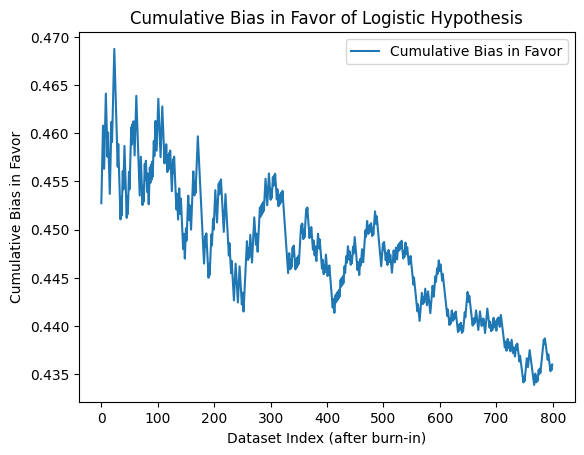

In [ ]:
# Call the function
bias_in_favour = hypothesis_bias_in_favour_logistic(
    n_sample=n_sample,
    X=X,
    hyp_betas=hyp_betas,
    delta=delta,
    prior_mu=prior_mu,
    prior_sigma=prior_sigma,
    n_datasets=n_datasets,
    n_marginal=n_marginal,
    cumulative=cumulative
)

# Visualize the cumulative bias in favor (if cumulative=True)
if cumulative:
    plt.plot(bias_in_favour, label="Cumulative Bias in Favor")
    plt.xlabel("Dataset Index (after burn-in)")
    plt.ylabel("Cumulative Bias in Favor")
    plt.title("Cumulative Bias in Favor of Logistic Hypothesis")
    plt.legend()
    plt.show()
else:
    print(f"Final Bias in Favor: {bias_in_favour}")


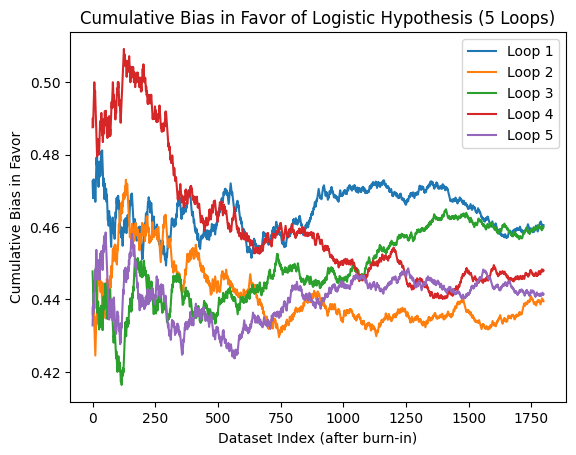

In [ ]:
# Run the function 5 times and store results
n_datasets = 2000  # Number of datasets to simulate
n_loops = 5
results = []

for i in range(n_loops):
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )
    results.append(bias_in_favour)

    # Plot the cumulative bias for this loop
    plt.plot(bias_in_favour, label=f"Loop {i+1}")

# Customize and display the plot
plt.xlabel("Dataset Index (after burn-in)")
plt.ylabel("Cumulative Bias in Favor")
plt.title("Cumulative Bias in Favor of Logistic Hypothesis (5 Loops)")
plt.legend()
plt.show()

Varying sample size

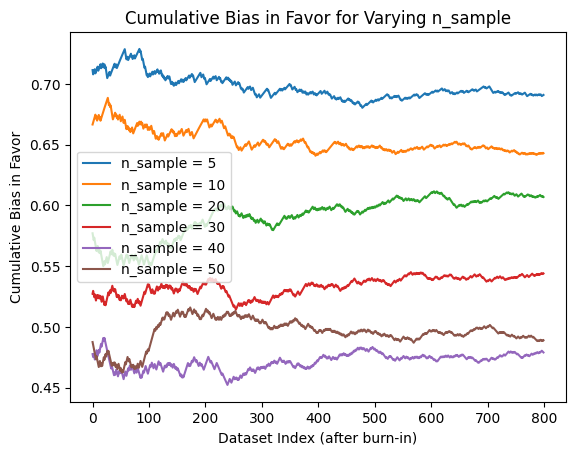

In [ ]:
# Define parameters
n_samples = [5, 10, 20, 30, 40, 50]  # Varying sample sizes
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.5  # Perturbation for hypothesis testing

# Initialize plot
plt.figure()

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )

    # Plot the cumulative bias for this n_sample
    plt.plot(bias_in_favour, label=f"n_sample = {n_sample}")

# Customize and display the plot
plt.xlabel("Dataset Index (after burn-in)")
plt.ylabel("Cumulative Bias in Favor")
plt.title("Cumulative Bias in Favor for Varying n_sample")
plt.legend()
plt.show()

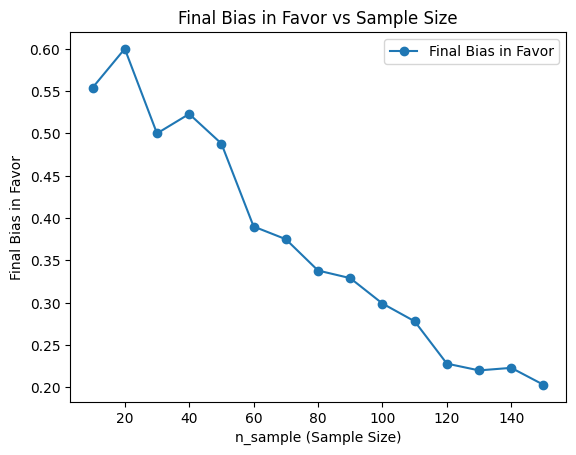

In [ ]:
n_samples = list(range(10, 150 + 1, 10))
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.5  # Perturbation for hypothesis testing


final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, marker='o', label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

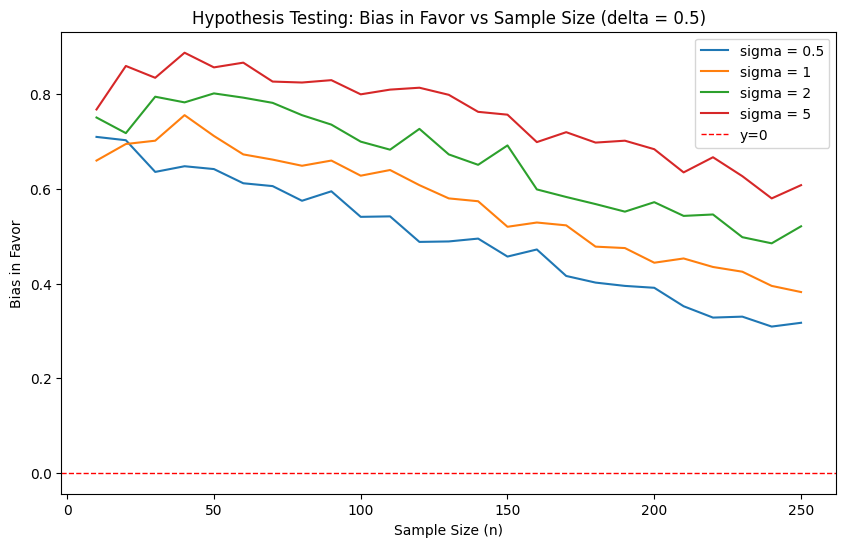

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
n_samples = list(range(10, 250 + 1, 10))  # Sample sizes
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.5  # Perturbation for hypothesis testing
sigmas = [0.5, 1, 2, 5]  # Varying sigma values
hyp_betas = np.array([0.0, 0.0])  # Hypothesized coefficients
prior_mu = np.zeros(n_param)  # Prior mean

# Store results for each sigma
results = {sigma: [] for sigma in sigmas}

# Loop through varying sigma and sample size
for sigma in sigmas:
    for n_sample in n_samples:
        # Generate a synthetic design matrix X
        X = np.ones((n_sample, len(hyp_betas)))
        X[:int(n_sample / 2), 0] = 0
        X[0:-1:2, 1] = 0

        # Call the function
        bias_in_favour = hypothesis_bias_in_favour_logistic(
            n_sample=n_sample,
            X=X,
            hyp_betas=hyp_betas,
            delta=delta,
            prior_mu=prior_mu,
            prior_sigma=sigma * np.eye(n_param),  # Scale prior covariance by sigma
            n_datasets=n_datasets,
            n_marginal=n_marginal,
            cumulative=True,
        )

        # Compute the final bias (last cumulative value)
        results[sigma].append(bias_in_favour[-1])

# Plot results
plt.figure(figsize=(10, 6))
for sigma, biases in results.items():
    plt.plot(n_samples, biases, label=f"sigma = {sigma}")

# Customize the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias in Favor")
plt.title("Hypothesis Testing: Bias in Favor vs Sample Size (delta = 0.5)")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label="y=0")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
n_samples = list(range(10, 250 + 1, 10))  # Sample sizes
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 1  # Perturbation for hypothesis testing
sigmas = [0.5, 1, 2, 5]  # Varying sigma values
hyp_betas = np.array([0.0, 0.0])  # Hypothesized coefficients
prior_mu = np.zeros(n_param)  # Prior mean

# Store results for each sigma
results = {sigma: [] for sigma in sigmas}

# Loop through varying sigma and sample size
for sigma in sigmas:
    for n_sample in n_samples:
        # Generate a synthetic design matrix X
        X = np.ones((n_sample, len(hyp_betas)))
        X[:int(n_sample / 2), 0] = 0
        X[0:-1:2, 1] = 0

        # Call the function
        bias_in_favour = hypothesis_bias_in_favour_logistic(
            n_sample=n_sample,
            X=X,
            hyp_betas=hyp_betas,
            delta=delta,
            prior_mu=prior_mu,
            prior_sigma=sigma * np.eye(n_param),  # Scale prior covariance by sigma
            n_datasets=n_datasets,
            n_marginal=n_marginal,
            cumulative=True,
        )

        # Compute the final bias (last cumulative value)
        results[sigma].append(bias_in_favour[-1])

# Plot results
plt.figure(figsize=(10, 6))
for sigma, biases in results.items():
    plt.plot(n_samples, biases, label=f"sigma = {sigma}")

# Customize the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias in Favor")
plt.title("Hypothesis Testing: Bias in Favor vs Sample Size (delta = 0.5)")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label="y=0")
plt.legend()
plt.show()


Varying prior sigma

σ = 0.5, δ = 1

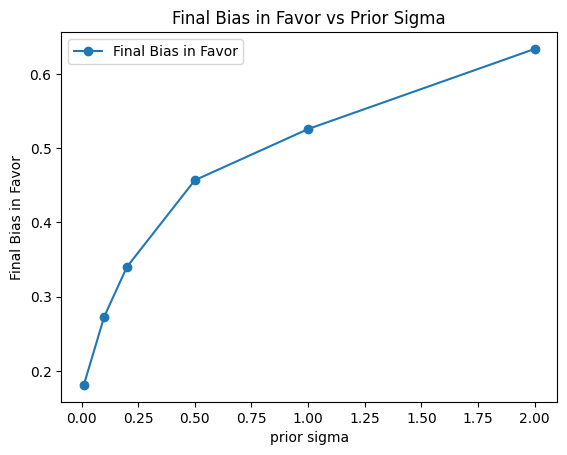

In [ ]:
n_samples = 100
n_param = 2  # Number of parameters (features) in the logistic model
delta = 0.5  # Perturbation for hypothesis testing
sigmas = list([0.01, 0.1, 0.2, 0.5, 1, 2])

X = np.ones((n_sample, len(hyp_betas)))
X[:int(n_sample / 2), 0] = 0
X[0:-1:2, 1] = 0

final_bias_values = []

# Loop through varying n_sample
for sigma in sigmas:
    prior_sigma = sigma*np.eye(n_param)

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(sigmas, final_bias_values, marker = 'o', label="Final Bias in Favor")
plt.xlabel("prior sigma")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Prior Sigma")
plt.legend()
plt.show()

σ = 1, δ = 1

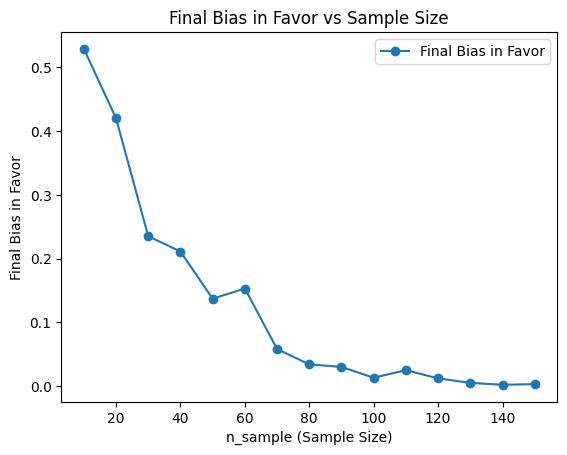

In [ ]:
n_samples = list(range(10, 150 + 1, 10))
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 1  # Perturbation for hypothesis testing


final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, marker='o', label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

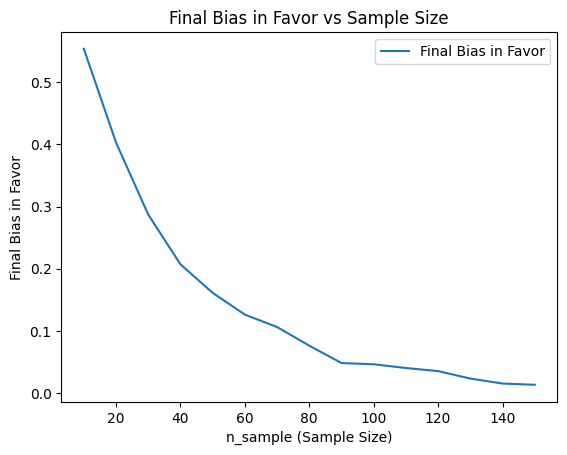

In [ ]:
n_samples = list(range(10, 150 + 1, 10))
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 1  # Perturbation for hypothesis testing
prior_sigma = 0.25*np.eye(n_param)

final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

σ = 0.1, δ = 1

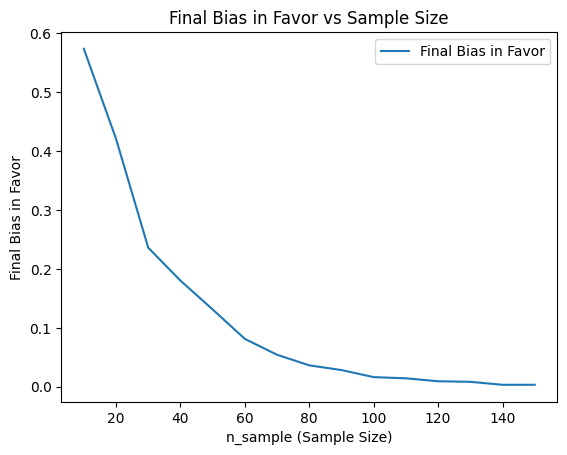

In [ ]:
n_samples = list(range(10, 150 + 1, 10))
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 1  # Perturbation for hypothesis testing
prior_sigma = 0.01*np.eye(n_param)

final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

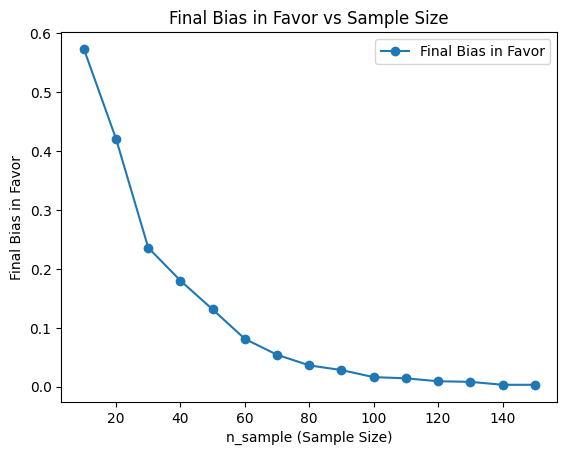

In [ ]:
plt.plot(n_samples, final_bias_values, marker = 'o', label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

### Prior centered at null with σ = 0.5 (δ = 0.5)

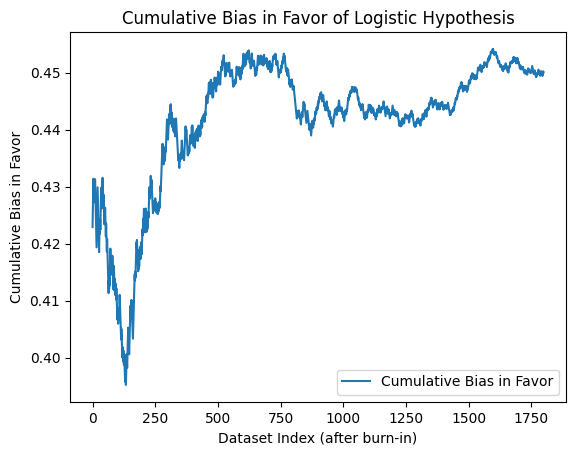

In [ ]:
# Define parameters
n_sample = 100 # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 2000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.5  # Perturbation for hypothesis testing
prior_mu = [0.0, 0.0] # Mean of the prior distribution for betas
prior_sigma = 0.25 * np.eye(n_param)  # Covariance matrix of the prior
cumulative = True  # Return cumulative bias against
hyp_betas = np.array([0.0, 0.0]) # Hypothesized beta coefficients

# Generate a synthetic design matrix X
X = np.ones((n_sample, len(hyp_betas)))
X[:int(n_sample/2), 0] = 0
X[0:-1:2, 1] = 0

# Call the function
bias_in_favour = hypothesis_bias_in_favour_logistic(
    n_sample=n_sample,
    X=X,
    hyp_betas=hyp_betas,
    delta=delta,
    prior_mu=prior_mu,
    prior_sigma=prior_sigma,
    n_datasets=n_datasets,
    n_marginal=n_marginal,
    cumulative=cumulative
)

# Visualize the cumulative bias in favor (if cumulative=True)
if cumulative:
    plt.plot(bias_in_favour, label="Cumulative Bias in Favor")
    plt.xlabel("Dataset Index (after burn-in)")
    plt.ylabel("Cumulative Bias in Favor")
    plt.title("Cumulative Bias in Favor of Logistic Hypothesis")
    plt.legend()
    plt.show()
else:
    print(f"Final Bias in Favor: {bias_in_favour}")


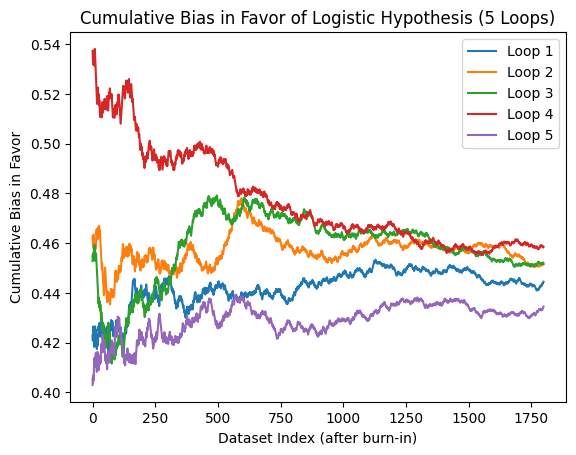

In [ ]:
n_sample = 100 # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 2000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.5 # Perturbation for hypothesis testing

# Generate a synthetic design matrix X
X = np.ones((n_sample, len(hyp_betas)))
X[:int(n_sample/2), 0] = 0
X[0:-1:2, 1] = 0

# Run the function 5 times and store results
n_loops = 5
results = []

for i in range(n_loops):
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )
    results.append(bias_in_favour)

    # Plot the cumulative bias for this loop
    plt.plot(bias_in_favour, label=f"Loop {i+1}")

# Customize and display the plot
plt.xlabel("Dataset Index (after burn-in)")
plt.ylabel("Cumulative Bias in Favor")
plt.title("Cumulative Bias in Favor of Logistic Hypothesis (5 Loops)")
plt.legend()
plt.show()

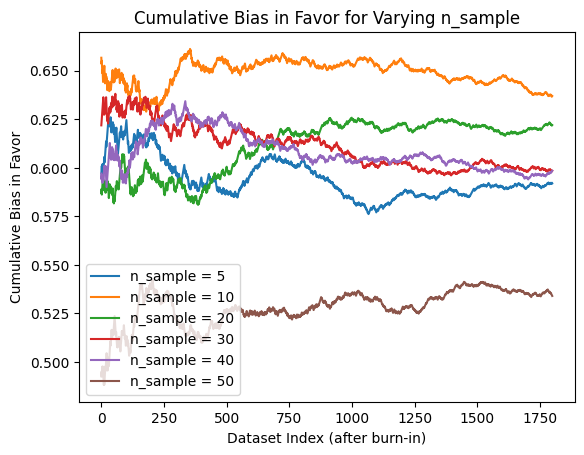

In [ ]:
# Define parameters
n_samples = [5, 10, 20, 30, 40, 50]  # Varying sample sizes

# Initialize plot
plt.figure()

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )

    # Plot the cumulative bias for this n_sample
    plt.plot(bias_in_favour, label=f"n_sample = {n_sample}")

# Customize and display the plot
plt.xlabel("Dataset Index (after burn-in)")
plt.ylabel("Cumulative Bias in Favor")
plt.title("Cumulative Bias in Favor for Varying n_sample")
plt.legend()
plt.show()

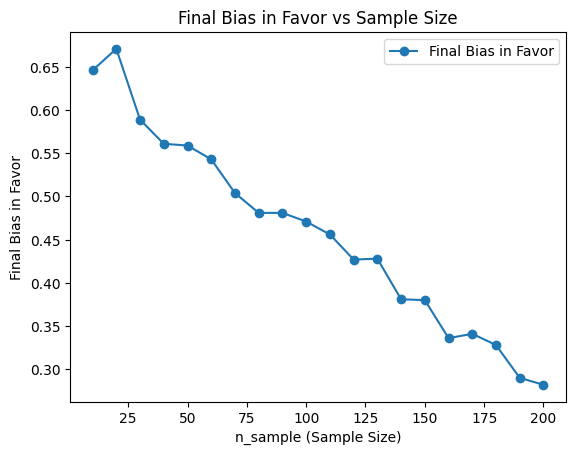

In [ ]:
n_samples = list(range(10, 200 + 1, 10))
prior_sigma = 0.25 * np.eye(n_param)  # Covariance matrix of the prior

final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, marker='o', label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

### Prior centered at null with σ = 1 (δ = 0.5)

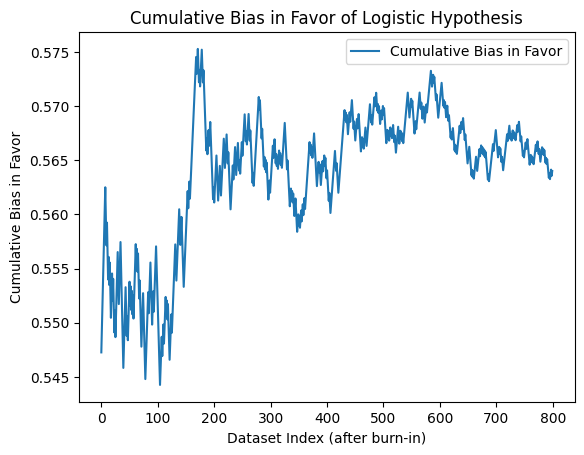

In [ ]:
# Define parameters
prior_sigma = np.eye(n_param)  # Covariance matrix of the prior

# Call the function
bias_in_favour = hypothesis_bias_in_favour_logistic(
    n_sample=n_sample,
    X=X,
    hyp_betas=hyp_betas,
    delta=delta,
    prior_mu=prior_mu,
    prior_sigma=prior_sigma,
    n_datasets=n_datasets,
    n_marginal=n_marginal,
    cumulative=cumulative
)

# Visualize the cumulative bias in favor (if cumulative=True)
if cumulative:
    plt.plot(bias_in_favour, label="Cumulative Bias in Favor")
    plt.xlabel("Dataset Index (after burn-in)")
    plt.ylabel("Cumulative Bias in Favor")
    plt.title("Cumulative Bias in Favor of Logistic Hypothesis")
    plt.legend()
    plt.show()
else:
    print(f"Final Bias in Favor: {bias_in_favour}")


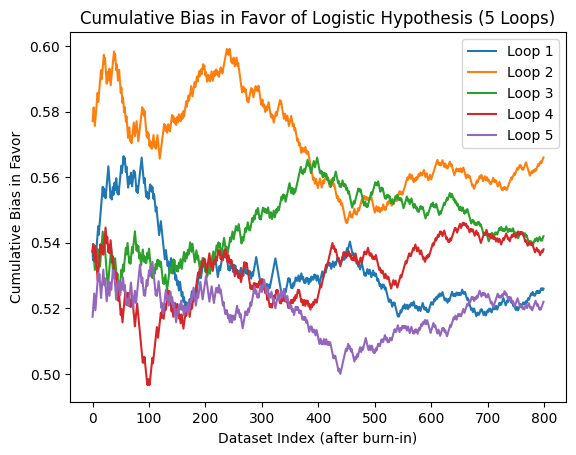

In [ ]:
prior_sigma = np.eye(n_param)  # Covariance matrix of the prior

# Run the function 5 times and store results
n_loops = 5
results = []

for i in range(n_loops):
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )
    results.append(bias_in_favour)

    # Plot the cumulative bias for this loop
    plt.plot(bias_in_favour, label=f"Loop {i+1}")

# Customize and display the plot
plt.xlabel("Dataset Index (after burn-in)")
plt.ylabel("Cumulative Bias in Favor")
plt.title("Cumulative Bias in Favor of Logistic Hypothesis (5 Loops)")
plt.legend()
plt.show()

Varying sample size

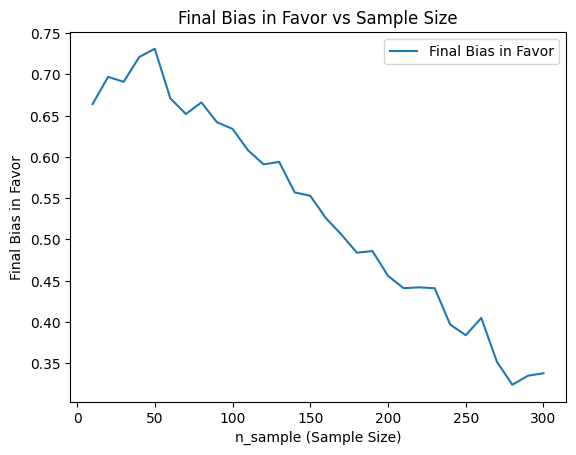

In [ ]:
n_samples = list(range(10, 300 + 1, 10))
prior_sigma = np.eye(n_param)

final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

δ = 0.1

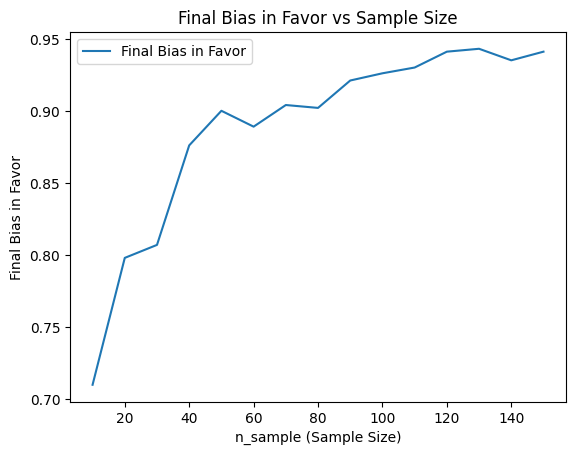

In [ ]:
n_samples = list(range(10, 150 + 1, 10))
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.1  # Perturbation for hypothesis testing
prior_sigma = np.eye(n_param)

final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

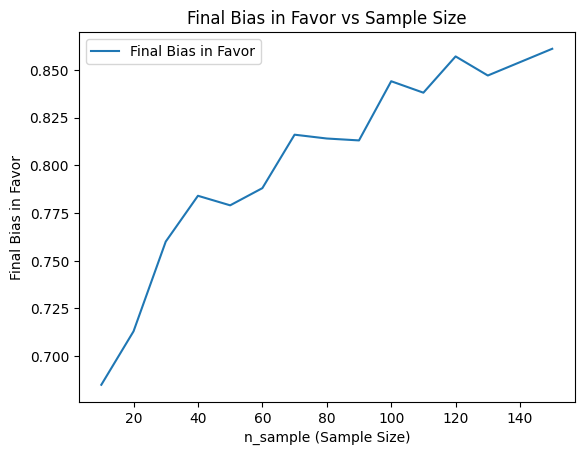

In [ ]:
n_samples = list(range(10, 150 + 1, 10))
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.1  # Perturbation for hypothesis testing
prior_sigma = 0.25*np.eye(n_param)

final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

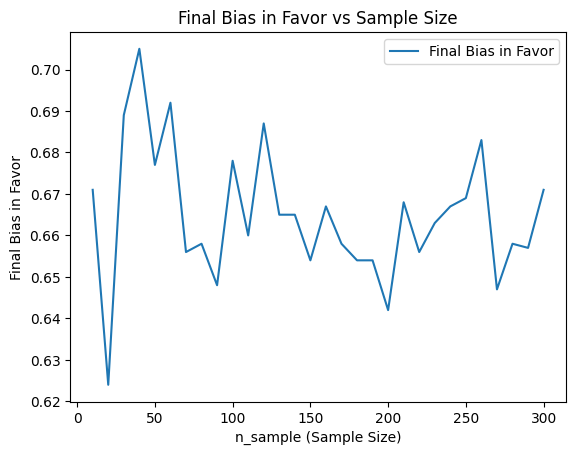

In [ ]:
n_samples = list(range(10, 300 + 1, 10))
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 0.1  # Perturbation for hypothesis testing
prior_sigma = 0.01*np.eye(n_param)

final_bias_values = []

# Loop through varying n_sample
for n_sample in n_samples:
    # Generate a synthetic design matrix X
    X = np.ones((n_sample, len(hyp_betas)))
    X[:int(n_sample / 2), 0] = 0
    X[0:-1:2, 1] = 0

    # Call the function
    bias_in_favour = hypothesis_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        hyp_betas=hyp_betas,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=True
    )

    # Compute the final bias (last cumulative value)
    final_bias_values.append(bias_in_favour[-1])

# Plot final bias vs n_sample
plt.plot(n_samples, final_bias_values, label="Final Bias in Favor")
plt.xlabel("n_sample (Sample Size)")
plt.ylabel("Final Bias in Favor")
plt.title("Final Bias in Favor vs Sample Size")
plt.legend()
plt.show()

^ seems like the bias in favour goes out of control when δ is small like 0.1. I tried increasing sample size and decreasing sigma, all were not very helpful.

# Estimation Bias In Favour

In [ ]:
def estimation_bias_in_favour_logistic(
    n_sample,
    X,
    n_param,
    n_iter,
    delta,
    prior_mu,
    prior_sigma,
    n_datasets = 1000,
    n_marginal = 1000,
    cumulative = False
):
    beta_0_samples = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_iter)
    sampled_betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_marginal)

    max_biases = np.zeros(n_iter)

    for i, beta in enumerate(beta_0_samples):
        # Array to store biases for theta = theta_0 + delta and theta_0 - delta
        biases = []
        for j in range(len(beta)):
              for shift in [+delta, -delta]:
                shifted_betas = beta.copy()
                shifted_betas[j] += shift  # Shift only the i-th parameter
                # print(shifted_betas)

          # Generate data from the hypothesized betas along with the input design matrix
                true_logits = X @ shifted_betas
                true_p = np.exp(true_logits) / (1 + np.exp(true_logits))
                y = np.random.binomial(1, p = true_p, size = (n_datasets, n_sample))

          # Calculate true logits and probabilities based on hyp_betas
                logits = X @ beta
                p = np.exp(logits) / (1 + np.exp(logits))

          # Compute log-likelihood of y given the hypothesis
                log_likelihood = binom_log_likelihood(p, y)
                total_log_likelihood = log_likelihood.sum(axis=1)

                logits_pri = X @ sampled_betas.T
                p_pri = np.exp(logits_pri) / (1 + np.exp(logits_pri))
                y_repeated = np.repeat(y[:, np.newaxis, :], n_marginal, axis=1)
                y_repeated = y_repeated.transpose(2, 1, 0)

                # Calculate log-likelihood for each y given p, then sum across samples
                log_likelihood = binom_log_likelihood(p_pri[..., np.newaxis], y_repeated)  # Shape: (n_sample, n_marginal, n_datasets)
                log_likelihoods = log_likelihood.sum(axis=0)  # Sum over samples; result shape: (n_marginal, n_datasets)
                # Compute log marginal likelihood across all beta samples
                log_marginal_likelihood = logsumexp(log_likelihoods, axis=0) - np.log(n_marginal)

                biases_in_fav = np.array([(total_log_likelihood - log_marginal_likelihood) > 0])

                final_bias = biases_in_fav.mean()

                # Store the bias for this delta sign
                biases.append(final_bias)

              max_biases[i] = max(biases)

    bias_in_favor_estimate = max_biases.mean()

        # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        return max_biases.cumsum() / np.arange(1, len(max_biases) + 1)  # Return cumulative bias after burn-in
    else:
        return bias_in_favor_estimate  # Return final bias in favor value

In [ ]:
# Define parameters
n_sample = 50  # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 100  # Number of iterations (beta samples)
delta = 1 # Perturbation amount
prior_mu = np.zeros(n_param) # Mean of the prior distribution for betas
prior_sigma = 0.01*np.eye(n_param)  # Covariance matrix of the prior
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = True  # Whether to compute cumulative bias or final estimate

# Generate a synthetic design matrix X
X = np.ones((n_sample, n_param))
X[:int(n_sample/2), 0] = 0
X[0:-1:2, 1] = 0  # Random design matrix

In [ ]:
# Define parameters
n_sample = 50  # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 100  # Number of iterations (beta samples)
delta = 1 # Perturbation amount
prior_mu = np.zeros(n_param) # Mean of the prior distribution for betas
prior_sigma = 0.01*np.eye(n_param)  # Covariance matrix of the prior
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = True  # Whether to compute cumulative bias or final estimate

# Generate a synthetic design matrix X
X = np.ones((n_sample, n_param))
X[:int(n_sample/2), 0] = 0
X[0:-1:2, 1] = 0  # Random design matrix

# Call the estimation_bias_in_favour_logistic function
bias_estimate = estimation_bias_in_favour_logistic(
    n_sample=n_sample,
    X=X,
    n_param=n_param,
    n_iter=n_iter,
    delta=delta,
    prior_mu=prior_mu,
    prior_sigma=prior_sigma,
    n_datasets=n_datasets,
    n_marginal=n_marginal,
    cumulative=cumulative
)

# Visualize the cumulative bias in favor (if cumulative=True)
if cumulative:
    plt.plot(bias_estimate, label="Cumulative Bias in Favor")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Bias in Favor")
    plt.title("Cumulative Bias in Favor of Logistic Hypothesis")
    plt.legend()
    plt.show()
else:
    print(f"Final Bias in Favor Estimate: {bias_estimate}")


KeyboardInterrupt: 

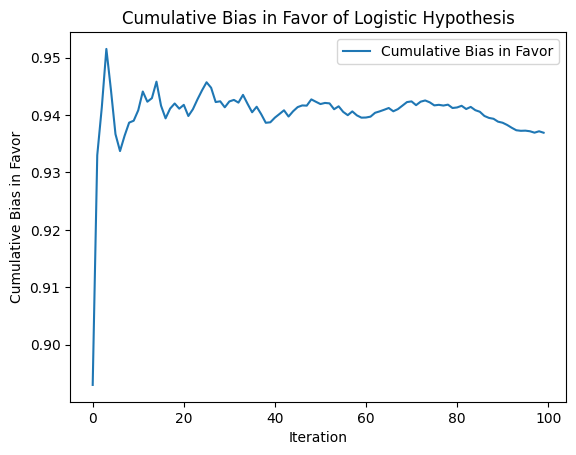

In [ ]:
# Define parameters
n_sample = 50  # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 100  # Number of iterations (beta samples)
delta = 0.1  # Perturbation amount
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
prior_sigma = np.eye(n_param)  # Covariance matrix of the prior
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = True  # Whether to compute cumulative bias or final estimate

# Generate a synthetic design matrix X
X = np.ones((n_sample, n_param))
X[:int(n_sample/2), 0] = 0
X[0:-1:2, 1] = 0  # Random design matrix

# Call the function
bias_estimate = estimation_bias_in_favour_logistic(
    n_sample=n_sample,
    X=X,
    n_param=n_param,
    n_iter=n_iter,
    delta=delta,
    prior_mu=prior_mu,
    prior_sigma=prior_sigma,
    n_datasets=n_datasets,
    n_marginal=n_marginal,
    cumulative=cumulative
)

# Visualize the cumulative bias in favor (if cumulative=True)
if cumulative:
    plt.plot(bias_estimate, label="Cumulative Bias in Favor")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Bias in Favor")
    plt.title("Cumulative Bias in Favor of Logistic Hypothesis")
    plt.legend()
    plt.show()
else:
    print(f"Final Bias in Favor Estimate: {bias_estimate}")


In [ ]:
# Define parameters
n_sample = 50  # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 100  # Number of iterations (beta samples)
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
prior_sigma = np.eye(n_param)  # Covariance matrix of the prior
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = False  # Return final bias estimate for each delta

# Generate a synthetic design matrix X
X = np.ones((n_sample, n_param))
X[:int(n_sample/2), 0] = 0
X[0:-1:2, 1] = 0  # Random design matrix

# Define deltas to vary
deltas = [0.1, 0.25, 0.5, 1.0]  # Different perturbation amounts
bias_estimates = []  # Store bias estimates for each delta

# Loop through varying deltas
for delta in deltas:
    # Call the function with the current delta
    bias_estimate = estimation_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        n_param=n_param,
        n_iter=n_iter,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )
    bias_estimates.append(bias_estimate)

# Plot results
plt.plot(deltas, bias_estimates, marker='o', label="Bias Estimate vs Delta")
plt.xlabel("Delta (Perturbation)")
plt.ylabel("Bias Estimate")
plt.title("Bias in Favor vs Perturbation Amount (Delta)")
plt.legend()
plt.show()


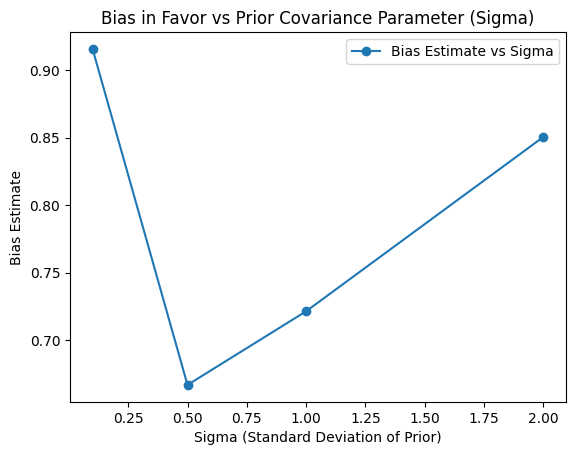

In [ ]:
# Define parameters
n_sample = 50  # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 50  # Number of iterations (beta samples)
delta = 1 # Perturbation amount
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = False  # Return final bias estimate for each sigma

# Define sigma values to vary
sigmas = [0.1, 0.5, 1.0, 2.0]  # Standard deviations for the prior
bias_estimates = []  # Store bias estimates for each sigma

# Loop through varying sigma values
for sigma in sigmas:
    # Adjust the prior covariance matrix
    prior_sigma = (sigma ** 2) * np.eye(n_param)  # Covariance matrix with sigma^2 as diagonal elements

    # Call the function with the current sigma
    bias_estimate = estimation_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        n_param=n_param,
        n_iter=n_iter,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )
    bias_estimates.append(bias_estimate)

# Plot results
plt.plot(sigmas, bias_estimates, marker='o', label="Bias Estimate vs Sigma")
plt.xlabel("Sigma (Standard Deviation of Prior)")
plt.ylabel("Bias Estimate")
plt.title("Bias in Favor vs Prior Covariance Parameter (Sigma)")
plt.legend()
plt.show()


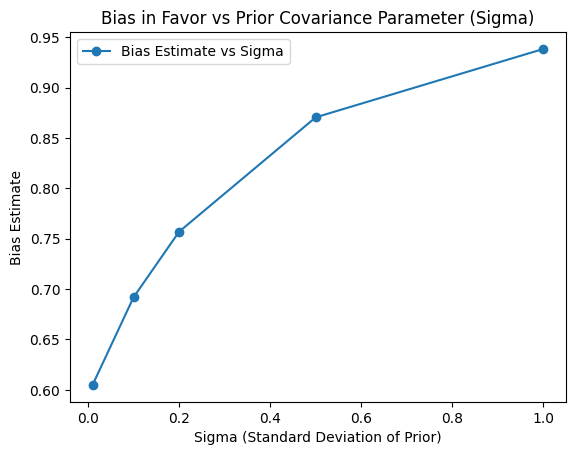

In [ ]:
# Define parameters
n_sample = 50  # Number of samples per dataset
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 60  # Number of iterations (beta samples)
delta = 0.1  # Perturbation amount
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = False  # Return final bias estimate for each sigma

# Define sigma values to vary
sigmas = [0.01, 0.1, 0.2, 0.5, 1]  # Standard deviations for the prior
bias_estimates = []  # Store bias estimates for each sigma

# Loop through varying sigma values
for sigma in sigmas:
    # Adjust the prior covariance matrix
    prior_sigma = (sigma ** 2) * np.eye(n_param)  # Covariance matrix with sigma^2 as diagonal elements

    # Call the function with the current sigma
    bias_estimate = estimation_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        n_param=n_param,
        n_iter=n_iter,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )
    bias_estimates.append(bias_estimate)

# Plot results
plt.plot(sigmas, bias_estimates, marker='o', label="Bias Estimate vs Sigma")
plt.xlabel("Sigma (Standard Deviation of Prior)")
plt.ylabel("Bias Estimate")
plt.title("Bias in Favor vs Prior Covariance Parameter (Sigma)")
plt.legend()
plt.show()


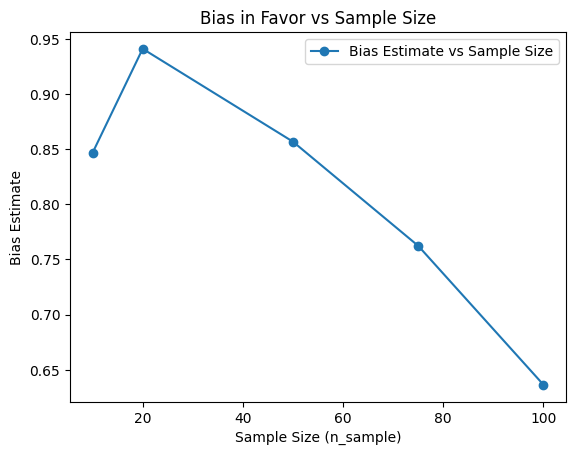

In [ ]:
# Define parameters
n_samples = [10, 20, 50, 75, 100]  # Different sample sizes to vary
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 100  # Number of iterations (beta samples)
delta = 1  # Perturbation amount
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
prior_sigma = 0.01*np.eye(n_param)  # Covariance matrix of the prior
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = False  # Return final bias estimate for each sample size

bias_estimates = []  # Store bias estimates for each sample size

# Loop through varying sample sizes
for n_sample in n_samples:
    # Generate a synthetic design matrix X for the current sample size
    X = np.random.randn(n_sample, n_param)  # Random design matrix

    # Call the function with the current sample size
    bias_estimate = estimation_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        n_param=n_param,
        n_iter=n_iter,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )
    bias_estimates.append(bias_estimate)

# Plot results
plt.plot(n_samples, bias_estimates, marker='o', label="Bias Estimate vs Sample Size")
plt.xlabel("Sample Size (n_sample)")
plt.ylabel("Bias Estimate")
plt.title("Bias in Favor vs Sample Size")
plt.legend()
plt.show()

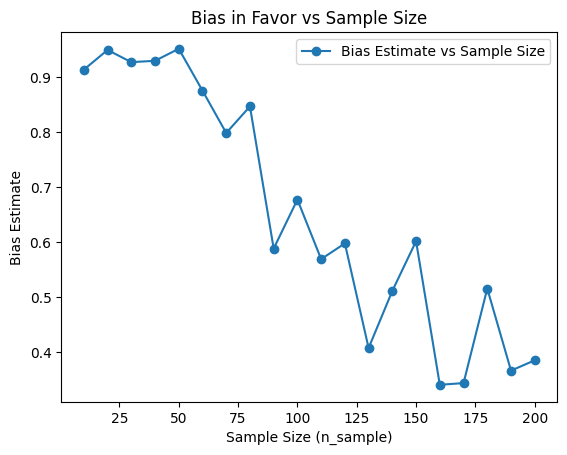

In [ ]:
# Define parameters
n_samples = list(range(10, 200 + 1, 10))# Different sample sizes to vary
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 50  # Number of iterations (beta samples)
delta = 1  # Perturbation amount
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
prior_sigma = 0.01*np.eye(n_param)  # Covariance matrix of the prior
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = False  # Return final bias estimate for each sample size

bias_estimates = []  # Store bias estimates for each sample size

# Loop through varying sample sizes
for n_sample in n_samples:
    # Generate a synthetic design matrix X for the current sample size
    X = np.random.randn(n_sample, n_param)  # Random design matrix

    # Call the function with the current sample size
    bias_estimate = estimation_bias_in_favour_logistic(
        n_sample=n_sample,
        X=X,
        n_param=n_param,
        n_iter=n_iter,
        delta=delta,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative
    )
    bias_estimates.append(bias_estimate)

# Plot results
plt.plot(n_samples, bias_estimates, marker='o', label="Bias Estimate vs Sample Size")
plt.xlabel("Sample Size (n_sample)")
plt.ylabel("Bias Estimate")
plt.title("Bias in Favor vs Sample Size")
plt.legend()
plt.show()

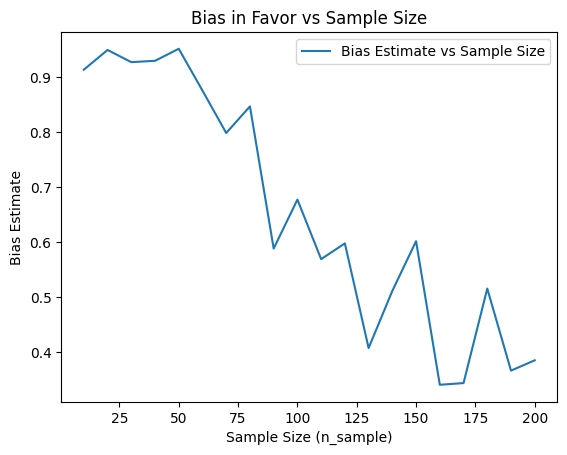

In [ ]:
plt.plot(n_samples, bias_estimates, label="Bias Estimate vs Sample Size")
plt.xlabel("Sample Size (n_sample)")
plt.ylabel("Bias Estimate")
plt.title("Bias in Favor vs Sample Size")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters
n_loops = 3  # Number of simulation loops for averaging
n_sample = 100  # Fixed sample size
deltas = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0]  # Varying delta values (x-axis)
sigmas = [0.5, 1, 2, 5]  # Varying sigma values
n_param = 2  # Number of parameters (features)
n_iter
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of marginal samples
prior_mu = np.zeros(n_param)  # Prior mean
cumulative = True  # Whether to calculate cumulative bias

# Store results
results = {sigma: {delta: [] for delta in deltas} for sigma in sigmas}

# Generate a synthetic design matrix X
X = np.ones((n_sample, n_param))
X[:int(n_sample / 2), 0] = 0
X[0:-1:2, 1] = 0

# Run simulations for multiple loops
for sim in range(n_loops):
    for sigma in sigmas:
        for delta in deltas:
            # Call the function for each sigma and delta
            bias_in_favour = estimation_bias_in_favour_logistic(
                n_sample=n_sample,
                X=X,
                hyp_betas=prior_mu,  # Assuming hyp_betas matches prior_mu
                delta=delta,
                prior_mu=prior_mu,
                prior_sigma=sigma * np.eye(n_param),  # Scale prior covariance
                n_datasets=n_datasets,
                n_marginal=n_marginal,
                cumulative=cumulative,
            )

            # Store the final bias value (last cumulative value)
            results[sigma][delta].append(bias_in_favour[-1])

# Calculate mean and confidence intervals
mean_results = {sigma: [] for sigma in sigmas}
conf_intervals = {sigma: [] for sigma in sigmas}

for sigma in sigmas:
    for delta in deltas:
        biases = results[sigma][delta]
        mean_bias = np.mean(biases)
        std_error = np.std(biases) / np.sqrt(n_loops)  # Standard error
        z_score = norm.ppf(0.975)  # For 95% confidence interval
        conf_interval = z_score * std_error

        mean_results[sigma].append(mean_bias)
        conf_intervals[sigma].append(conf_interval)

# Plot results with color-coded confidence intervals
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sigmas)))  # Generate distinct colors

for idx, sigma in enumerate(sigmas):
    mean_bias = mean_results[sigma]
    conf_interval = conf_intervals[sigma]
    lower_bound = [m - c for m, c in zip(mean_bias, conf_interval)]
    upper_bound = [m + c for m, c in zip(mean_bias, conf_interval)]

    # Plot the mean line
    plt.plot(deltas, mean_bias, linestyle='--', label=f"sigma = {sigma}", color=colors[idx])

    # Fill the confidence interval
    plt.fill_between(
        deltas,
        lower_bound,
        upper_bound,
        alpha=0.2,
        color=colors[idx],
    )

# Add a red horizontal line at y=0
plt.axhline(y=0, color='red', linewidth=1,)

# Customize the plot
plt.xlabel("Delta")
plt.ylabel("Bias in Favor")
plt.title("Hypothesis Testing: Bias in Favor vs Delta")
plt.legend()
plt.show()
